<h1>Asos Trustpilot Reviews</h1>
<h2>Objectives</h2>
I made a purchase from ASOS (a fashion retailer) recently. I decided to check their trustpilot reviews shortly after I finished the order. I was shocked to see a very low average score as I had heard their service was generally good. The same applies to other big companies I have used services from such as Amazon, Netflix and Microsoft, they all have low scores.<br><br>
Looking at the reviews, some issues seemed genuine but many seemed very angry rants and not useful reviews, I thought I would try to formulate a better review score and see if there is any reasoning or patterns behined these bad reviews.

<h4>Data Source</h4>
This data was scraped from the trustpilot website, which could have been collected manually and required no additional access or sign up. In addition the scraper I used complied with their Robots.txt file. I do not wish to share the scraper code here out of respect for the website. They do run a proper API data feed with better information than we can scrape (importantly, user age, since it might help identify demographics) but it seems it is only available to their enterprise users.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize
from wordcloud import WordCloud,STOPWORDS

df_longs_lats = pd.read_csv('/kaggle/input/world-capitals-gps/concap.csv')

df_users = pd.read_csv('/kaggle/input/asos-trustpilot-reviews/asos_reviews/asos_reviews/user_info_v3.csv')
df_users.columns = ['row-no','location','review count','userid']
df_asos = pd.read_csv('/kaggle/input/asos-trustpilot-reviews/asos_reviews/asos_reviews/asos_reviews_v2.csv')
df_asos.columns = ['row-no','rating','review body','review datetime','review title','userid']
df_supp = pd.read_csv('/kaggle/input/asos-trustpilot-reviews/asos_reviews/asos_reviews/supplementary_reviews_v2.csv')
df_supp.columns = ['row-no','rating','review body','review datetime','review title','userid']

In [2]:
def clean(x):
    x = x.replace("\n", "")
    x = x.strip()
    return str(x)

df_users['location'] = df_users['location'].apply(clean)

df_asos['review datetime'] = pd.to_datetime(df_asos['review datetime'])
df_supp['review datetime'] = pd.to_datetime(df_supp['review datetime'])

number of reviews 2016: 748


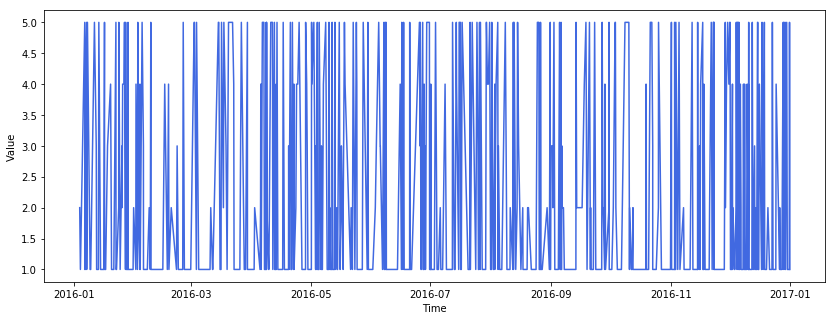

number of reviews 2017: 920


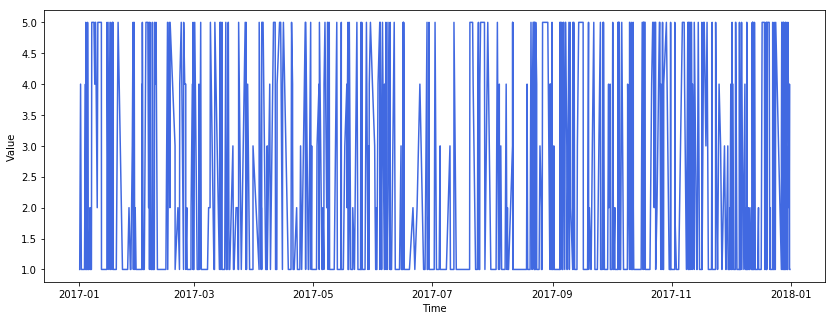

number of reviews 2018: 1734


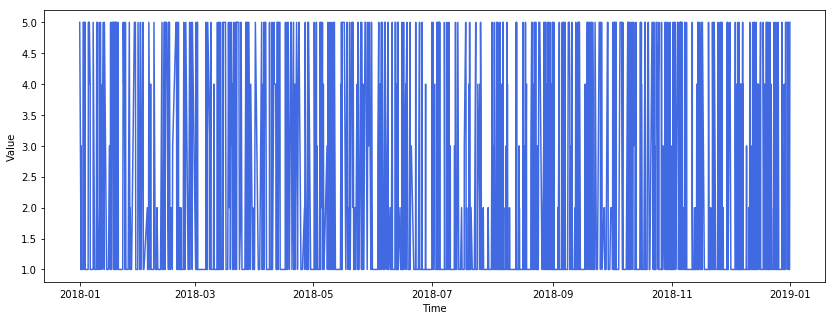

number of reviews 2019: 1593


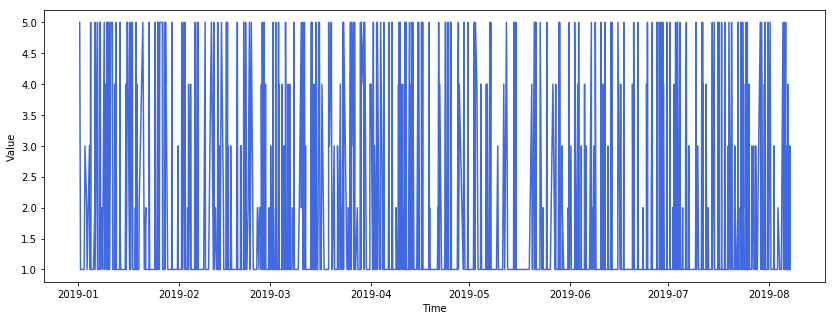

In [3]:
for i in range(2016,2020):
    print('number of reviews '+str(i)+':',
          len(df_asos.loc[df_asos['review datetime'].dt.year == i]['review datetime']))
    fig, ax = plt.subplots(figsize=(14,5))
    ax.plot(df_asos.loc[df_asos['review datetime'].dt.year == i]['review datetime'],
            df_asos.loc[df_asos['review datetime'].dt.year == i]['rating'], color='royalblue')
    plt.ylabel("Value")
    plt.xlabel("Time")
    plt.show()

There have been more reviews every year. Keeping that in mind, this looks relatively consistent. The parts where there are larger white gaps means there were only low scores during that period. That could be useful information for the business in identifying an issue and correcting it.

<b> Which countries do the Reviews come from? </b>

In [4]:
#get longitude and latitude for each country we will plot for
def getLat(x):
    mask = df_longs_lats['CountryName'] == x
    
    if df_longs_lats.loc[mask]['CapitalLatitude'].empty:
        return 'NotFound'
    
    return float(df_longs_lats.loc[mask]['CapitalLatitude'])

def getLong(x):
    mask = df_longs_lats['CountryName'] == x
    
    if df_longs_lats.loc[mask]['CapitalLongitude'].empty:
        return 'NotFound'
    
    return float(df_longs_lats.loc[mask]['CapitalLongitude'])
    
count_by_country = df_users['location'].value_counts()
df_countries = count_by_country.rename_axis('country').reset_index(name='counts')

df_countries['longitude'] = [getLong(x[1]['country']) for x in df_countries.iterrows()]
df_countries['latitude']  = [getLat(x[1]['country']) for x in df_countries.iterrows()]

df_countries = df_countries.loc[df_countries['longitude'] != 'NotFound']

df_countries.head()

,country,counts,longitude,latitude
0,United Kingdom,2439,-0.083333,51.5
1,United States,840,-77,38.8833
2,Denmark,181,12.5833,55.6667
3,Canada,177,-75.7,45.4167
4,Australia,131,149.133,-35.2667


In [5]:
#plot graph
limits = [(0,10),(11,100),(101,500),(501,5000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_countries[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'country names',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text =  df_sub['country'],
        marker = dict(
            size = df_sub['counts']/2,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = 'Asos Reviews country of origin (rankings 1 to 100 most reviews by location)<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'world',
            landcolor = 'rgb(217, 217, 217)'
        )
    )

fig.show()

We can see from the table and graph that most reviews are from the UK, but other big reviewers are USA, Canada, Australia, Singapore and Israel. The other reviews after this are largely from european countries.

In [6]:
len(df_users.loc[df_users['review count'] > 1]) / len(df_users)

0.48769753950790157

Only 48.7% of the users who reviewed asos also reviewed at least 1 other company. This means something Asos is doing is driving people to sign up and review on trustpilot.

<h4>Feature engineering using the date time</h4>

In [7]:
df_asos['hours'] = df_asos['review datetime'].dt.hour
df_asos['daylight'] = ((df_asos['hours'] >= 7) & (df_asos['hours'] <= 19)).astype(int)
df_asos['DayOfTheWeek'] = df_asos['review datetime'].dt.dayofweek
df_asos['WeekDay'] = (df_asos['DayOfTheWeek'] < 5).astype(int)

df_supp['hours'] = df_supp['review datetime'].dt.hour
df_supp['daylight'] = ((df_supp['hours'] >= 7) & (df_supp['hours'] <= 19)).astype(int)
df_supp['DayOfTheWeek'] = df_supp['review datetime'].dt.dayofweek
df_supp['WeekDay'] = (df_supp['DayOfTheWeek'] < 5).astype(int)

In [8]:
#make unix time epoch, easier for models to work with
df_asos['time_epoch'] = (df_asos['review datetime'].astype(np.int64)/100000000000).astype(np.int64)
df_supp['time_epoch'] = (df_supp['review datetime'].astype(np.int64)/100000000000).astype(np.int64)

In [9]:
#make categories for weekday or weekend, and day/night, 4 categories in total
df_asos['dnw_categ'] = df_asos['WeekDay']*2 + df_asos['daylight']
df_supp['dnw_categ'] = df_supp['WeekDay']*2 + df_supp['daylight']
#0 = weekend night,1= weekend day,2 = weekday night, 3 = weekday day

<h4>User Reviews and Reliability</h4>
Some ideas about the data are difficult to quantify numerically, so here are some further assumptions about the data:<br>

<b>Survival Bias</b><br>
Customers who received good service are much less likely to review on trustpilot to begin with because they have nothing to gain from it, they 'survived' in a sense. This means many 'reviews' we end up with are just angry, emotional rants which may or may not have any logical reasoning behind them.

<b>Common Wrongly Identified Service Issues</b><br>
Users often rate the company they have made purchases from poorly (Asos in this instace), even though it is often a delivery firm to blame for 'poor service'. This unfairly reflects on a company receiving the bad review as there is little they can do about an external supplier such as a delivery firm, although many of their users perhaps do not think about this relationship. <br> 

<b>Problem Customers / Expectations too high</b><br>
Some people are impossible to please. If the purchase of products and services are <b>independent events</b>, then it is statistically very unlikely someone always receives poor service. If a person has left more than one review for a company or for several companies, and all or most of them are negative, it's likely this person is an unreliable reviewer and has unrealistically high expectations when purchasing services or goods. Their opinion should carry less weight.

<b>Fake Reviews</b><br>
Some reviews could be fake, and idicator for this would perhaps be if all of a users reviews are overly positive. This needs to be addressed.


In [10]:
#unsurprisingly, the most common score is 1
print('most common score: ',int(df_supp['rating'].mode()))

low_averages = []
high_averages = []
for user in df_users['userid']:
    review_score_average = df_supp.loc[df_supp['userid'] == user]['rating'].mean()
    if review_score_average < 2.5:
        low_averages.append((user,review_score_average))
    
    if review_score_average > 3.5:
        high_averages.append((user,review_score_average))

print('number of low average score users:',len(low_averages))
print('number of high average score users:',len(high_averages))

most common score:  1
number of low average score users: 14
number of high average score users: 1


The above shows that there are a few 'problem customers' and very few people who are potentially posting 'fake' reviews, but not enough to be statistically significant. This is one concern taken care of.

<h4>Review difference by day/night, weekday/weekend, and distribution</h4>

In [11]:
def getRatinglistAsos(x):
    #x is a category
    ratings_count = []
    for y in range(1,6):
        ratings_count.append(len(df_asos.loc[(df_asos['dnw_categ'] == x) & (df_asos['rating'] == y)]))
    return ratings_count

grouped_lists = [getRatinglistAsos(i) for i in range(0,4)]

def getRatinglistSupp(x):
    #x is a category
    ratings_count = []
    for y in range(1,6):
        ratings_count.append(len(df_supp.loc[(df_supp['dnw_categ'] == x) & (df_supp['rating'] == y)]))
    return ratings_count

grouped_lists_supp = [getRatinglistSupp(i) for i in range(0,4)]

In [12]:
ratings=['1', '2', '3','4','5']

fig = go.Figure(data=[
    go.Bar(name='Weekend Night', x=ratings, y=grouped_lists[0]),
    go.Bar(name='Weekend day', x=ratings, y=grouped_lists[1]),
    go.Bar(name='Weekday Night',x=ratings,y=grouped_lists[2]),
    go.Bar(name='Weekday day',x=ratings,y=grouped_lists[3])   
])

fig.update_layout(barmode='group',
                title='Ratings counts by times they occur',
                xaxis=dict(title='Ratings'),yaxis=dict(title='Frequency of rating'))
fig.show()
#0 = weekend night,1= weekend day,2 = weekday night, 3 = weekday day

Overwhelmingly the most common review score is 1, regardless the day or night or weekend. Most 1 star reviews occur on weekday daytimes (between 7am and 8pm gmt). Proportionally speaking the most positive scores, 5 star reviews, occur in the week during the day time also.

In [13]:
ratings=['1', '2', '3','4','5']

fig = go.Figure(data=[
    go.Bar(name='Weekend Night', x=ratings, y=grouped_lists_supp[0]),
    go.Bar(name='Weekend day', x=ratings, y=grouped_lists_supp[1]),
    go.Bar(name='Weekday Night',x=ratings,y=grouped_lists_supp[2]),
    go.Bar(name='Weekday day',x=ratings,y=grouped_lists_supp[3])   
])

fig.update_layout(barmode='group',
                title='Ratings counts by times they occur',
                xaxis=dict(title='Ratings'),yaxis=dict(title='Frequency of rating'))
fig.show()

There is a similar pattern as before for 'all reviews', which are the supplementary reviews associated with the users who left asos a review. The difference is that the general reviews are much more positive with many more 5 star reviews, relatively speaking.
<h4>Takeaway from these group frequencies?</h4>
Given there are comparitively more 5 stars reviews amongst the same set of users for other services, it isn't unreasonable to beleive there could be issues and this isn't just people complaining over nothing.

<h2>Natural Language Processing (NLP)</h2>
<h4>Lazy Labeling</h4>
I have decided to label the sentiment of the reviews as follows, based on their rating. This seems sensible since someone who has given 5 stars is unlikely to have left a negative comment, and vice-versa:<br><br>
1 - 2 stars, Negative<br>
3 stars, Neutral<br>
4 -5 stars, Positive<br>

After the data is labelled I will produce a word cloud, so we can see how much of a problem things like delivery crop up in the negative reviews. We will also be able to see what people like about the company.

In [14]:
def getSentiment(rating):
    if rating == 1 or rating == 2:
        return 'Negative'
    if rating == 3:
        return 'Neutral'
    if rating == 4 or rating == 5:
        return 'Positive'
    #should never happen, but the fall through is that it should make no difference
    return 'Neutral'

df_asos['sentiment'] = [getSentiment(x) for x in df_asos['rating']]

<h3>Word Clouds</h3>
These will show us the most frequent positive and negative words in the reviews. For those unsure, STOPWORDS are words which commonly occur in english which don't add much sentiment to a sentence e.g (if, was, and, but, could, said) etc. so when cleaning for NLP we remove them.

Positive words


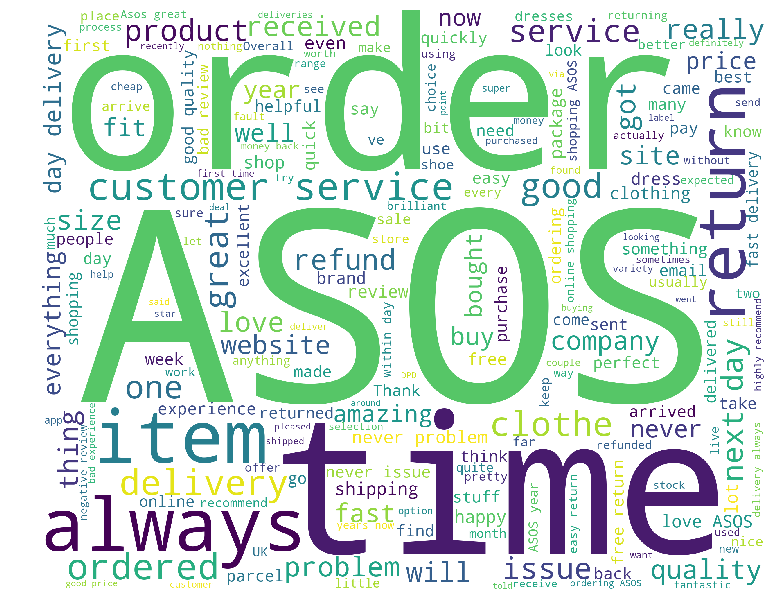

In [15]:
positive_reviews = df_asos.loc[df_asos['sentiment'] == 'Positive']['review body']
negative_reviews = df_asos.loc[df_asos['sentiment'] == 'Negative']['review body']

def makeWordcloud(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
makeWordcloud(positive_reviews,'white')

Amongst the positive reviews it seems the brand is very strong, being the biggest word here. Other things which people seem to like are the <b>returns and refunds</b>, as well as the word <b>"Always"</b>, which suggests a consistent and reliable service.

Negative words


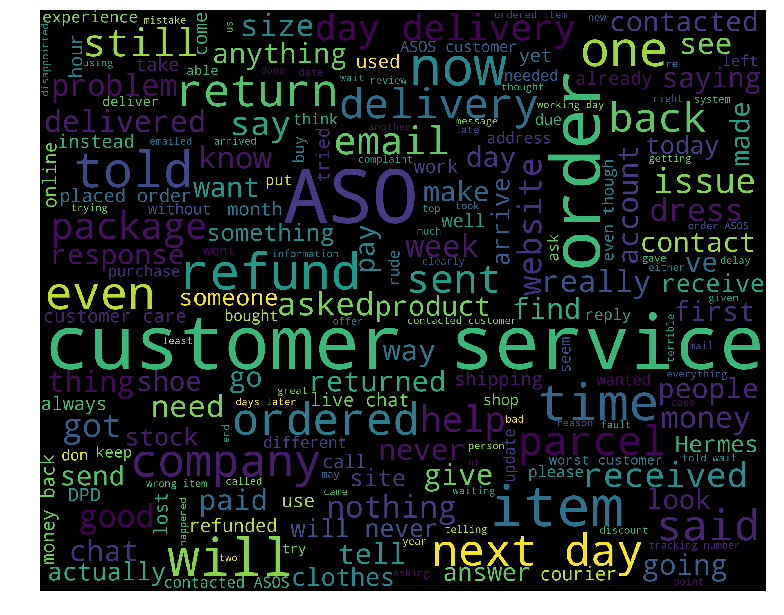

In [16]:
print("Negative words")
makeWordcloud(negative_reviews)

The biggest issue which jumps out is <b>Customer Service</b> and other issues related to that such as <b>Contact and Contacted, Live Chat</b>. Aside from those, The second biggest issues seem to be <b>Delivery</b> related and associated words such as <b>Parcel, Package, next day, time, day, DPD, Hermes</b>.<br>

<h3>Word frequency cloud (StopWords removed)</h3>

We will draw another word cloud, this time showing the most frequent words in the reviews.

In [17]:
#remove all the stopwords from the reviews
no_stopword_reviews = []
stopwords_set = set(stopwords.words("english"))

for index, row in enumerate(df_asos.iterrows()):
    body = row[1]['review body']
    words_filtered = [e.lower() for e in body.split() if len(e) >= 3]
    words_without_stopwords = [word for word in words_filtered if not word in stopwords_set]
    no_stopword_reviews.append((words_without_stopwords, df_asos['sentiment']))

In [18]:
def getWordsInReviews(reviews):
    all = []
    for (words, sentiment) in reviews:
        all.extend(words)
    return all

def getWordFeatures(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

def extractFeatures(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

word_features = getWordFeatures(getWordsInReviews(no_stopword_reviews))

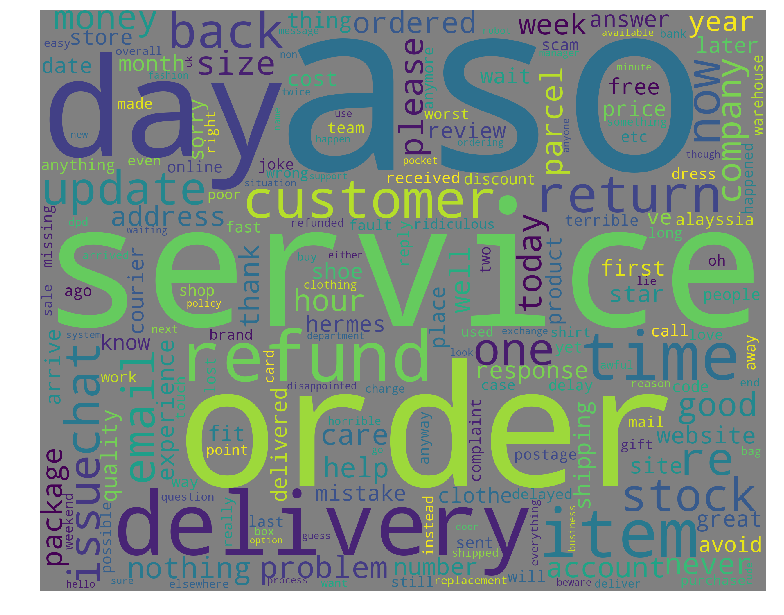

In [19]:
makeWordcloud(word_features,'gray')

Remember, these aren't considered positive or negative, they're just the most frequently occuring.

<h3>Deciding if a review is unreliable</h3>
* The following criteria will be used:<br>
* is this their only review? <br>
* was this review posted at the most common time angry emotional reviews are left? <br>
* is the review much longer than average in words? (longer reviews to me are evidence a person is unhappy and rambling) <br>
* does the review mention delivery?<br>


In [20]:
tokenizer = RegexpTokenizer(r'\W+')

review_word_counts = []
for review in df_asos['review body']:
    review_words = len(tokenizer.tokenize(review))
    review_word_counts.append(review_words)

df_asos['word count'] = review_word_counts
     
df_check = pd.DataFrame(review_word_counts,columns=['word count'])
q3 = int(df_check['word count'].quantile(0.75))

def reviewClassify(x):

    row = x[1]
    final_score = 0
    
    user_review_count = int(df_users.loc[df_users['userid'] == row['userid']]['review count'])

    #only one review, less reliable
    if user_review_count == 1:
        final_score = final_score + 0.3
        
    #most common time for angry comments/potential customer to blame, less reliable
    if row['dnw_categ'] == 3:
        final_score = final_score + 0.2
    
    #convert their review into word count, if the review is 
    #in the 75th or more percentile for word count
    #ignore it, it's probably a long story and rant
    word_count = tokenizer.tokenize(row['review body'])
    if len(word_count) >= q3:
        final_score = final_score + 0.3
    
    #if they've mentioned delivery, it's less reliable since
    #we already established delivery services can't be helped much by the actual company
    for i in sent_tokenize(row['review body']):
        if all(word in i for word in ['delivery']):
            final_score = final_score + 0.3
            #don't penalise them more than once for the word delivery
            break
    
    if final_score >= 0.6:
        result = 0 # not reliable
    if final_score < 0.6:
        result = 1 #reliable
    
    return result

df_asos['reliable']  = [reviewClassify(x) for x in df_asos.iterrows()]

In [21]:
print('percentage of reviews which are considered reliable: ',
      len(df_asos.loc[df_asos['reliable'] == 1]) / len(df_asos))


print('mean score, all reviews: ',df_asos['rating'].mean())
print('mean score, classified reviews:',df_asos.loc[df_asos['reliable'] == 1]['rating'].mean())

percentage of reviews which are considered reliable:  0.7149429885977195
mean score, all reviews:  2.0048009601920382
mean score, classified reviews: 2.166200335758254


As we can see, removing the very unreliable reviews does improve the score slightly. Additionally, now we have these labelled, if we get more reviews later we can use this existing data to use a proper classifier, such as support vector machine to classify reviews as we receive them.

<h3>Future Classification</h3>
A small svm model is going to be used to see if we can predict a reliable review from an unreliable one. In the real situation I would put in the extra work to make use of more features, but just as an example, I will use a few of the features that are easily available.

In [22]:
features = ['rating','dnw_categ','word count']

#before classifying these, take some for training/testing later
X_train, X_test, y_train, y_test = train_test_split(df_asos[features],df_asos['reliable']
                                                    ,test_size=0.2, random_state=0)


In [23]:
X_test['reliable'] = y_test
colorsIdx = {0: 'salmon', 1:'powderblue'}
cols      = X_test['reliable'].map(colorsIdx)

graph_fig = go.Figure(
    data=[go.Scatter(x=X_test['word count'], 
                     y=X_test['rating'],
                     mode='markers',
                     marker=dict(size=7,
                                 line=dict(width=1),
                                color=cols)
                    )],
    layout=go.Layout(
        title=go.layout.Title(text="word count against rating, ground truth")))
    
graph_fig.update_xaxes(title_text='word count')
graph_fig.update_yaxes(title_text='rating')

graph_fig.show()

We can see visually that the more words used, the more likely it is that the review is unreliable. Red = unreliable, blue = reliable.

In [24]:
svm = SVC(random_state=0,kernel='linear',C=0.025)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test[features])

X_test['reliable'] = y_pred
colorsIdx = {0: 'salmon', 1:'powderblue'}
cols      = X_test['reliable'].map(colorsIdx)

graph_fig = go.Figure(
    data=[go.Scatter(x=X_test['word count'], 
                     y=X_test['rating'],
                     mode='markers',
                     marker=dict(size=7,
                                 line=dict(width=1),
                                color=cols)
                    )],
    layout=go.Layout(
        title=go.layout.Title(text="word count against rating, predictions")))
    
graph_fig.update_xaxes(title_text='word count')
graph_fig.update_yaxes(title_text='rating')

graph_fig.show()

the classifier performed broadly quite well, given the limited information it has, the classification line seems ok.